In [1]:
import os
dir_path=os.path.dirname(os.path.realpath('adversarial example'))
os.chdir(dir_path)
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
%matplotlib inline
import matplotlib as mpl
import numpy as np

In [2]:
# The classification model part is borrowed from "Deep MNIST for Experts" 
mnist= tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.0,x_test/255.0

(60000, 28, 28)


<Figure size 432x288 with 0 Axes>

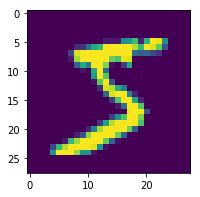

In [3]:
# Visualize the sample image
print(x_train.shape)
plt.clf()
plt.figure(figsize=(3, 3))
plt.imshow(x_train[0])
plt.show()

In [4]:
# build model, training the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 21s 352us/step - loss: 0.2220 - acc: 0.9348
Epoch 2/5
60000/60000 [==============================] - 21s 356us/step - loss: 0.0984 - acc: 0.9701
Epoch 3/5
60000/60000 [==============================] - 18s 307us/step - loss: 0.0698 - acc: 0.9781
Epoch 4/5
60000/60000 [==============================] - 19s 312us/step - loss: 0.0545 - acc: 0.9828
Epoch 5/5
10000/10000 [==============================] - 1s 73us/step


[0.06587726678787148, 0.9798]

In [79]:
# Use "The fast Gradient Sign Method" introduced in https://www.youtube.com/watch?v=CIfsB_EYsVI at time 27.32 
# Build a tensor for gradients (Jacobian matrix) of total_loss and model inputs
gradients=model.optimizer.get_gradients(model.total_loss,model.inputs)

# Set function to calculate the gradients, which is inspired by: The https://github.com/keras-team/keras/issues/2226
input_tensors = model.inputs+model.sample_weights+model.targets+[K.learning_phase()]
get_gradients=K.function(inputs=input_tensors,outputs=gradients)

# Sample image whose label is 2
two_index=np.where(y_test==2)[0]
np.random.seed(11)
sub_two_index=np.random.choice(two_index,10)
ori_image=x_test[sub_two_index]
ori_label=y_test[sub_two_index]


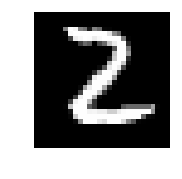

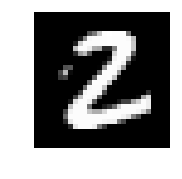

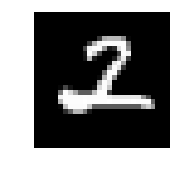

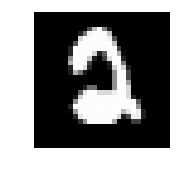

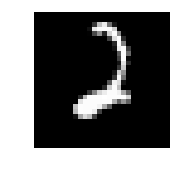

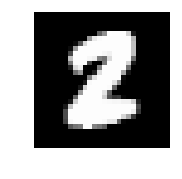

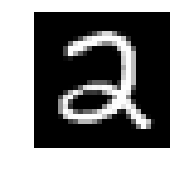

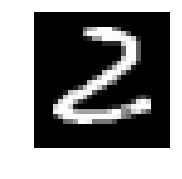

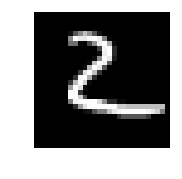

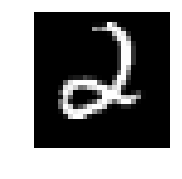

In [80]:
# Show the original images, correct, predicted label and confidence
for i in range(0, 10):
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(ori_image[i],cmap = "gray")
    plt.show()

In [81]:
# Put into a loop with fixed learning rate (Epsilon in Fast Gradient sign method) = 0.0001


adv_image=ori_image.copy()
i=0

#while not (np.argmax(model.predict(x),1)==6).all():
while i<10:
    inputs = [adv_image, # X
              np.ones(len(adv_image)), # sample weights
              [6 for i in ori_label], # y
              0 # learning phase in TEST mode
    ]
    gradient=get_gradients(inputs)[0]
    i+=1
#    print(i,model.predict(x)[0])
    print("probability of 2",model.predict(adv_image)[:,2])
    print("probability of 6",model.predict(adv_image)[:,6])
    adv_image=adv_image-0.03*np.sign(gradient)
print(i)

np.argmax(model.predict(adv_image)[0])

probability of 2 [0.9999956  0.999997   0.9996351  0.9808975  0.9999956  0.93147326
 0.99998    0.9998211  0.99855167 0.99999976]
probability of 6 [7.1823054e-14 1.3307031e-13 7.2160478e-09 1.5877821e-03 1.3952030e-07
 6.3918604e-09 2.5983327e-10 3.0971997e-13 5.1546333e-05 4.6881219e-08]
probability of 2 [1.         0.99999964 0.907927   0.23157531 0.9963085  0.45883912
 0.9996474  0.9999906  0.74192464 0.9999304 ]
probability of 6 [1.8522977e-18 6.4203054e-16 7.9253005e-06 6.2378442e-01 3.4218526e-03
 2.2310339e-06 2.1222920e-08 4.1959602e-15 1.7383675e-01 1.0842785e-05]
probability of 2 [1.0000000e+00 9.9987745e-01 2.7227101e-01 2.8025836e-04 1.8886652e-02
 1.3837896e-01 9.8832840e-01 9.9738544e-01 1.3033304e-03 9.5874506e-01]
probability of 6 [1.8522977e-18 1.2476491e-12 3.1782354e-03 9.9550444e-01 9.8007292e-01
 3.0798276e-04 8.7893641e-06 1.9251604e-11 9.9126679e-01 3.6006279e-02]
probability of 2 [1.0000000e+00 9.9995255e-01 1.1730283e-01 1.1646595e-06 6.0578185e-07
 6.9257677e-

2

True label 2
Predicted label: 6
Confidence: 1.0


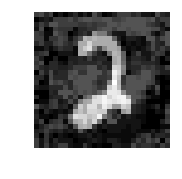

True label 2
Predicted label: 6
Confidence: 1.0


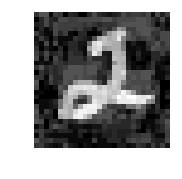

True label 2
Predicted label: 6
Confidence: 1.0


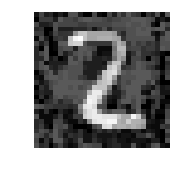

True label 2
Predicted label: 6
Confidence: 1.0


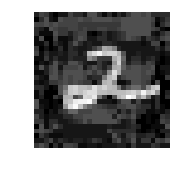

True label 2
Predicted label: 2
Confidence: 5.6058335e-16


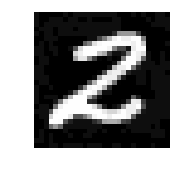

True label 2
Predicted label: 6
Confidence: 1.0


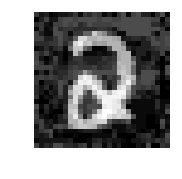

True label 2
Predicted label: 6
Confidence: 1.0


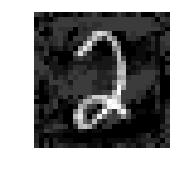

True label 2
Predicted label: 6
Confidence: 1.0


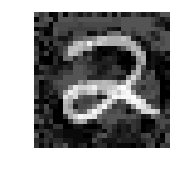

True label 2
Predicted label: 2
Confidence: 9.467819e-14


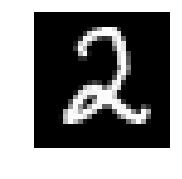

True label 2
Predicted label: 6
Confidence: 1.0


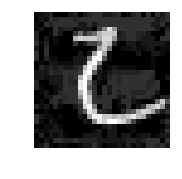

In [73]:
#Visualize the image and its probability.
for i in range(10):
    print('True label', 2)
    print('Predicted label:', np.argmax(model.predict(adv_image),1)[i])
    print('Confidence:', model.predict(adv_image[i:i+1])[0][6])
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(adv_image[i],cmap = "gray")
    plt.show()

In [ ]:
# Notice there are some failed adversarial example. I will get solution to deal with them later.

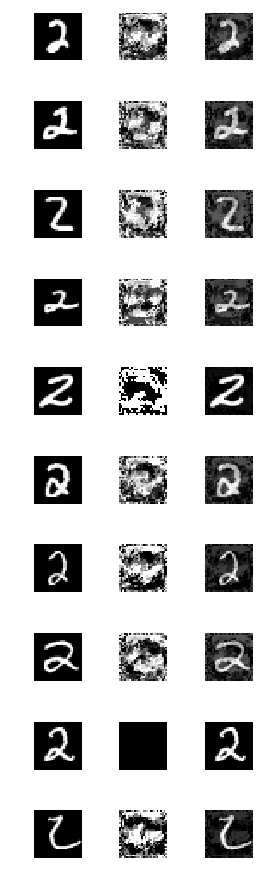

In [74]:
# Return image that asked
f, ax = plt.subplots(10, 3, figsize=(3,10))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 90
for i in range(10):
    for j in range(3):
        ax[i,j].set_axis_off()
    ax[i,0].imshow(ori_image[i], cmap = "gray")
    ax[i,1].imshow(adv_image[i]-ori_image[i], cmap = "gray")
    ax[i,2].imshow(adv_image[i], cmap="gray")


plt.tight_layout()
plt.show()

In [10]:
#Analyst the result:
# 1.
# A problem is found that, if an image have prediction probability of 2 = 1
# The gradient of this image to other classes will be 0
# so no matter how many time the loop goes, the algorithm can't make any change to the original picture, so that 
# no adversarial example will be generated
for i in two_index:
    if model.predict(x_test[i:i+1])[0][2]==1:
        k=i
        break
    if i==two_index[-1]:
        print("there is no qualified example in this model, you should re-train the model")
inputs = [x_test[k:k+1],np.ones(1),[6],0]
gradient=get_gradients(inputs)[0]
print(model.predict(x_test[k:k+1])[0])
print(gradient)

[1.2072534e-13 1.4883760e-12 1.0000000e+00 4.1402967e-10 9.7286126e-09
 4.2516362e-11 5.6643196e-10 9.2497017e-13 8.5313728e-13 1.1450551e-14]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [11]:
# for example:
np.random.seed(1)
two_index=np.where(y_test==2)[0]
sub_two_index=np.random.choice(two_index,10)
ori_image=x_test[sub_two_index]
ori_label=y_test[sub_two_index]

adv_image=ori_image.copy()
i=0
while i<10:
    inputs = [adv_image, # X
              np.ones(len(adv_image)), # sample weights
              [6 for i in ori_label], # y
              0 # learning phase in TEST mode
    ]
    gradient=get_gradients(inputs)[0]
    i+=1
    print("probability of 2",model.predict(adv_image)[:,2])
    print("probability of 6",model.predict(adv_image)[:,6])
    adv_image=adv_image-0.03*np.sign(gradient)
print('number of iteration:',i)

probability of 2 [0.9989484  0.9999988  0.99983335 0.9991817  0.99999416 0.99909866
 0.9782215  0.9999738  1.         0.999559  ]
probability of 6 [3.3559093e-11 3.0509620e-10 1.5142751e-12 1.0726539e-09 1.8496376e-12
 3.3237617e-09 6.6317585e-07 6.8074271e-09 9.4677833e-14 3.1915741e-04]
probability of 2 [0.989897   0.99997365 0.96122384 0.82873    1.         0.9981294
 0.4405327  0.97996557 1.         0.01620271]
probability of 6 [1.6133205e-08 1.1022011e-08 1.3163929e-08 7.0299485e-08 5.6058335e-16
 3.2570611e-07 2.5252709e-03 2.1726248e-06 9.4677833e-14 9.7973263e-01]
probability of 2 [9.30910826e-01 9.95915353e-01 5.03063858e-01 1.13428295e-01
 1.00000000e+00 9.40335691e-01 7.08744526e-02 4.61934209e-01
 1.00000000e+00 1.98613421e-07]
probability of 6 [4.6699952e-06 5.7876855e-06 1.1671166e-06 1.2696387e-05 5.6058335e-16
 6.5746217e-04 4.8211339e-01 9.2196779e-04 9.4677833e-14 9.9992585e-01]
probability of 2 [4.0697628e-01 8.3459651e-01 2.0956621e-02 2.8024432e-01 1.0000000e+00
 2

In [13]:
#To solve this problem, I add a random noise to the image which has predict probability > 0.99, which solved the problem. 


adv_image2=ori_image.copy()
i=0
while not (np.argmax(model.predict(adv_image2),1)==6).all() and i<40:
#while i<20:
    inputs = [adv_image2, # X
              np.ones(len(adv_image2)), # sample weights
              [6 for i in ori_label], # y
              0 # learning phase in TEST mode
    ]
    gradient=get_gradients(inputs)[0]
    i+=1
#    print(i,model.predict(x[0:1]))
    print("probability of 2",model.predict(adv_image2)[:,2])
    print("probability of 6",model.predict(adv_image2)[:,6])
# add random noise if predict probability > 0.99
    for j in range(len(adv_image2)):
        if model.predict(adv_image2)[:,2][j]>0.99:
            adv_image2[j]=adv_image2[j]+0.03*np.random.rand(adv_image2[j].shape[0],adv_image2[j].shape[1])
    adv_image2=adv_image2-0.03*np.sign(gradient)
print(i)

print("probability of 6",model.predict(adv_image2)[:,6])

probability of 2 [0.9989484  0.9999988  0.99983335 0.9991817  0.99999416 0.99909866
 0.9782215  0.9999738  1.         0.999559  ]
probability of 6 [3.3559093e-11 3.0509620e-10 1.5142751e-12 1.0726539e-09 1.8496376e-12
 3.3237617e-09 6.6317585e-07 6.8074271e-09 9.4677833e-14 3.1915741e-04]
probability of 2 [0.99056226 0.9999639  0.9420645  0.8439945  1.         0.9979594
 0.4405327  0.97962415 0.9999999  0.01494606]
probability of 6 [2.3303365e-08 2.3451785e-08 3.0871131e-08 2.8028634e-07 9.7778942e-16
 4.6593496e-07 2.5252709e-03 2.9765035e-06 3.2062162e-13 9.7961217e-01]
probability of 2 [9.3987185e-01 9.9973851e-01 4.9334753e-01 3.5615823e-01 1.0000000e+00
 9.5573115e-01 7.0874453e-02 4.5967746e-01 9.9996591e-01 3.6805210e-07]
probability of 6 [6.6682833e-06 1.9394533e-05 4.2107731e-06 5.4555468e-04 1.3478510e-15
 6.4683449e-04 4.8211339e-01 1.0750308e-03 2.7239739e-09 9.9991632e-01]
probability of 2 [5.5071950e-01 9.5012653e-01 2.6380686e-02 3.3855087e-01 1.0000000e+00
 3.3374721e-0

probability of 6 [1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.9263782e-04
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00]
probability of 2 [2.5016939e-10 2.7320265e-10 4.5215871e-12 8.7493700e-11 5.0012851e-01
 1.1771751e-09 1.4223478e-10 3.3235492e-10 3.6090018e-09 8.3981129e-13]
probability of 6 [1.         1.         1.         1.         0.05693683 1.
 1.         1.         1.         1.        ]
28
probability of 6 [1.        1.        1.        1.        0.7210832 1.        1.
 1.        1.        1.       ]


Correct label 2
Predicted label: 6
Confidence: 1.0


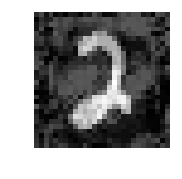

Correct label 2
Predicted label: 6
Confidence: 1.0


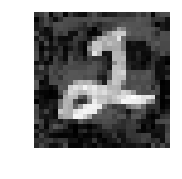

Correct label 2
Predicted label: 6
Confidence: 1.0


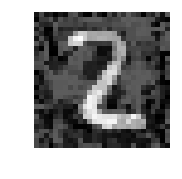

Correct label 2
Predicted label: 6
Confidence: 1.0


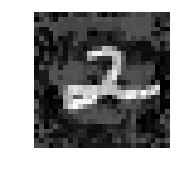

Correct label 2
Predicted label: 6
Confidence: 0.72108334


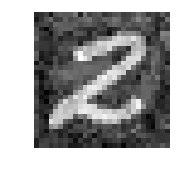

Correct label 2
Predicted label: 6
Confidence: 1.0


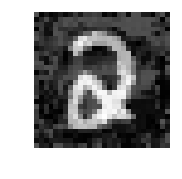

Correct label 2
Predicted label: 6
Confidence: 1.0


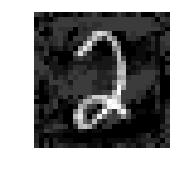

Correct label 2
Predicted label: 6
Confidence: 1.0


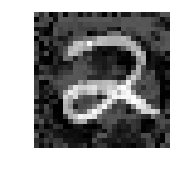

Correct label 2
Predicted label: 6
Confidence: 1.0


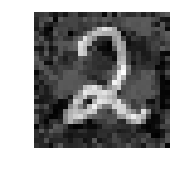

Correct label 2
Predicted label: 6
Confidence: 1.0


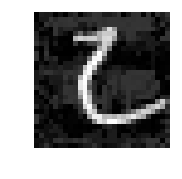

In [14]:
#Visualize the image and its probability.
for i in range(10):
    print('Correct label', 2)
    print('Predicted label:', np.argmax(model.predict(adv_image2),1)[i])
    print('Confidence:', model.predict(adv_image2[i:i+1])[0][6])
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(adv_image2[i],cmap = "gray")
    plt.show()

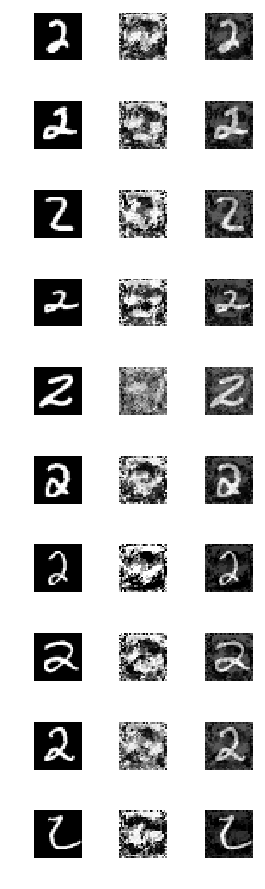

In [75]:
# Return image that asked
f, ax = plt.subplots(10, 3, figsize=(3,10))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 90
for i in range(10):
    ax[i,0].set_axis_off()
    ax[i,1].set_axis_off()
    ax[i,2].set_axis_off()
    ax[i,0].imshow(ori_image[i], cmap = "gray")
    ax[i,1].imshow(adv_image2[i]-ori_image[i], cmap = "gray")
    ax[i,2].imshow(adv_image2[i], cmap="gray")


plt.tight_layout()
plt.show()
f.savefig("result.png")

In [ ]:
from keras import initializations

def my_init(shape, name=None):
    return initializations.normal(shape, scale=0.01, name=name)

model.add(Dense(64, init=my_init))

In [47]:
# 2. See if the adversarial example useful in different model.

# Same model with random initial weight
# Analyst: The miss classfify rate is 0, however the overall accuracy is not so high as original one.
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu,kernel_initializer='random_normal',bias_initializer='random_normal'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax,kernel_initializer='random_normal',bias_initializer='random_normal')
])
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(x_train, y_train, epochs=10)
model2.evaluate(x_test, y_test)
sum(np.argmax(model2.predict(adv_image),1)==6)/10

Epoch 1/10
60000/60000 [==============================] - 20s 341us/step - loss: 7.3391 - acc: 0.5355
Epoch 2/10
60000/60000 [==============================] - 18s 299us/step - loss: 3.9811 - acc: 0.7457
Epoch 3/10
60000/60000 [==============================] - 21s 352us/step - loss: 3.3278 - acc: 0.7882
Epoch 4/10
60000/60000 [==============================] - 24s 393us/step - loss: 3.0597 - acc: 0.8056
Epoch 5/10
60000/60000 [==============================] - 24s 401us/step - loss: 2.8887 - acc: 0.8163
Epoch 6/10
60000/60000 [==============================] - 18s 305us/step - loss: 2.7902 - acc: 0.8233
Epoch 7/10
60000/60000 [==============================] - 18s 301us/step - loss: 2.6816 - acc: 0.8301
Epoch 8/10
60000/60000 [==============================] - 18s 296us/step - loss: 2.5739 - acc: 0.8368
Epoch 9/10
60000/60000 [==============================] - 19s 316us/step - loss: 2.5027 - acc: 0.8414
Epoch 10/10
10000/10000 [==============================] - 2s 186us/step


0.0

In [48]:
# model with similiar structure
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(x_train, y_train, epochs=5)
model3.evaluate(x_test, y_test)
sum(np.argmax(model3.predict(adv_image),1)==6)/10

Epoch 1/5
60000/60000 [==============================] - 25s 418us/step - loss: 0.1996 - acc: 0.9400
Epoch 2/5
60000/60000 [==============================] - 21s 342us/step - loss: 0.0847 - acc: 0.9741
Epoch 3/5
60000/60000 [==============================] - 24s 397us/step - loss: 0.0606 - acc: 0.9805
Epoch 4/5
60000/60000 [==============================] - 21s 348us/step - loss: 0.0462 - acc: 0.9856
Epoch 5/5
10000/10000 [==============================] - 2s 169us/step


0.8

In [45]:
# Add a Gaussian Noise to input image
# Analyst: Add Gaussian Noise is a good way to deal with adversarial examples
model4 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.GaussianNoise(0.3),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(x_train, y_train, epochs=5)
model4.evaluate(x_test, y_test)
sum(np.argmax(model4.predict(adv_image),1)==6)/10

Epoch 1/5
60000/60000 [==============================] - 19s 321us/step - loss: 0.3286 - acc: 0.8982
Epoch 2/5
60000/60000 [==============================] - 18s 304us/step - loss: 0.1756 - acc: 0.9449
Epoch 3/5
60000/60000 [==============================] - 18s 305us/step - loss: 0.1445 - acc: 0.9538
Epoch 4/5
60000/60000 [==============================] - 18s 305us/step - loss: 0.1264 - acc: 0.9602
Epoch 5/5
10000/10000 [==============================] - 1s 115us/step


0.1

In [70]:
# Bagging, 5 same models trained with different subset of training data
model5 = []
for i in range(5):
    model5.append(tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]))
    model5[i].compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    bag_index=np.random.choice(60000,36000)
    model5[i].fit(x_train[bag_index], y_train[bag_index], epochs=5)
    model5[i].evaluate(x_test, y_test)

Epoch 1/5
36000/36000 [==============================] - 14s 392us/step - loss: 0.2623 - acc: 0.9229
Epoch 2/5
36000/36000 [==============================] - 11s 301us/step - loss: 0.1081 - acc: 0.9678
Epoch 3/5
36000/36000 [==============================] - 11s 300us/step - loss: 0.0676 - acc: 0.9787
Epoch 4/5
36000/36000 [==============================] - 11s 311us/step - loss: 0.0478 - acc: 0.9855
Epoch 5/5
10000/10000 [==============================] - 2s 169us/step
Epoch 1/5
36000/36000 [==============================] - 14s 383us/step - loss: 0.2620 - acc: 0.9237
Epoch 2/5
36000/36000 [==============================] - 13s 358us/step - loss: 0.1076 - acc: 0.9685
Epoch 3/5
36000/36000 [==============================] - 11s 316us/step - loss: 0.0693 - acc: 0.9800
Epoch 4/5
36000/36000 [==============================] - 12s 337us/step - loss: 0.0479 - acc: 0.9862
Epoch 5/5
10000/10000 [==============================] - 2s 178us/step
Epoch 1/5
36000/36000 [===========================

In [71]:
# All the sub_model give the same results with the adversarial examples, which is quite funy.
result=[]
for i in range(5):
    result.append(np.argmax(model5[i].predict(adv_image),1))
result

[array([6, 6, 6, 6, 2, 6, 6, 6, 2, 6]),
 array([6, 6, 6, 6, 2, 6, 6, 6, 2, 6]),
 array([6, 6, 6, 6, 2, 6, 6, 6, 2, 6]),
 array([6, 6, 6, 6, 2, 6, 6, 6, 2, 6]),
 array([6, 6, 6, 6, 2, 6, 6, 6, 2, 6])]